##**Importing Libraries**

In [ ]:
import os
import cv2
import time
import torch
import matplotlib
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from tqdm.notebook import tqdm
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

##**Installing Torch-Summary & Enabling GPU**

In [ ]:
!pip install -q torchsummary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

##**Downloading & Unzipping Dataset**

In [ ]:
!gdown https://drive.google.com/file/d/1QB-pQUfy-sG0b-g3FPpIBIweNfuUeKkD/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1QB-pQUfy-sG0b-g3FPpIBIweNfuUeKkD
To: /content/A3_Dataset.zip
100% 126M/126M [00:01<00:00, 77.4MB/s]


In [ ]:
!unzip /content/A3_Dataset.zip

Archive:  /content/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.png  
 

##**Loading Dataset**

In [ ]:
IMAGE_PATH_TRAIN = "/content/A3_Dataset/dataset1/images_prepped_train/"
MASK_PATH_TRAIN = "/content/A3_Dataset/dataset1/annotations_prepped_train/"

IMAGE_PATH_TEST = "/content/A3_Dataset/dataset1/images_prepped_test/"
MASK_PATH_TEST = "/content/A3_Dataset/dataset1/annotations_prepped_test/"

In [ ]:
n_classes = 12

def create_df(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_trainval = create_df(IMAGE_PATH_TRAIN)
df_test = create_df(IMAGE_PATH_TEST)

print('Total number of images for training  : ', len(df_trainval))
print('Total number of images for testing   : ', len(df_test))

Total number of images for training  :  367
Total number of images for testing   :  101


In [ ]:
X_train, X_val = train_test_split(df_trainval['id'].values, test_size=0.2, random_state=19)
X_test = df_test.to_numpy()
X_test = X_test.reshape((len(X_test),))

print('Train Size       : ', len(X_train))
print('Validation Size  : ', len(X_val))
print('Test Size        : ', len(X_test))

Train Size       :  293
Validation Size  :  74
Test Size        :  101


In [ ]:
print(matplotlib.rcParams['image.cmap'])

viridis


##**Visualizing An Image From Dataset**

Image Size : (360, 480, 3)
Mask Size  : (360, 480)


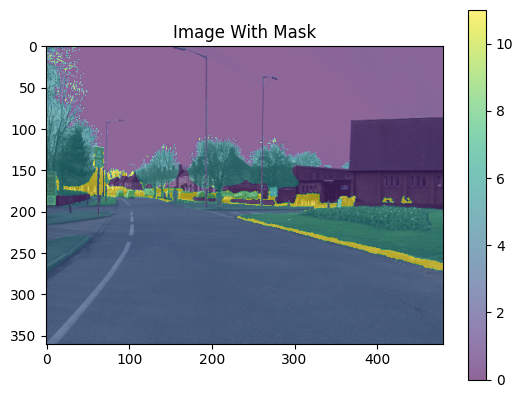

In [ ]:
img = Image.open(IMAGE_PATH_TRAIN + '/' + df_trainval['id'][100] + '.png')
mask = Image.open(MASK_PATH_TRAIN + '/' + df_trainval['id'][100] + '.png')

print('Image Size :', np.asarray(img).shape)
print('Mask Size  :', np.asarray(mask).shape)

plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Image With Mask')
plt.colorbar(msk)
plt.show()

##**Data Transform / Augmentation**

In [ ]:
# transform / augmentation for the train and validation sets

class cityscape(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [ ]:
# transform / augmentation for the test set

class cityscape_test(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)
test_set = cityscape_test(IMAGE_PATH_TEST, MASK_PATH_TEST, X_test, transform=t_test)

In [ ]:
def calc_mean_std(dataset_path):
    
    mean_accumulator = np.zeros(3)
    std_accumulator = np.zeros(3)

    num_images = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                image_path = os.path.join(root, file)

                image = cv2.imread(image_path)

                image = image.astype(np.float32) / 255.0

                per_channel_mean = np.mean(image, axis=(0, 1))
                per_channel_std = np.std(image, axis=(0, 1))

                mean_accumulator += per_channel_mean
                std_accumulator += per_channel_std

                num_images += 1

    mean = mean_accumulator / num_images
    std = std_accumulator / num_images

    return mean, std

mean, std = calc_mean_std(IMAGE_PATH_TRAIN)

In [ ]:
mean = [mean[0], mean[1], mean[2]]
std  = [std[0], std[1], std[2]]

print("Per-channel mean               :", mean)
print("Per-channel standard deviation :", std)

Per-channel mean               : [0.43248152708487547, 0.42495101402013763, 0.411717101606751]
Per-channel standard deviation : [0.2828402714524672, 0.28505572132583534, 0.2741312475555274]


In [ ]:
t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), A.GaussNoise()])
t_val   = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

train_set = cityscape(IMAGE_PATH_TRAIN, MASK_PATH_TRAIN, X_train, mean, std, t_train)
val_set   = cityscape(IMAGE_PATH_TRAIN, MASK_PATH_TRAIN, X_val, mean, std, t_val)

batch_size = 5 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=True)

##**Defining Helper Functions**

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=12):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, 5):
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [ ]:
def f1_score(pred_mask, mask):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        tp = torch.logical_and(pred_mask, mask).sum().float().item()
        fp = (pred_mask - mask).eq(1).sum().float().item()
        fn = (mask - pred_mask).eq(1).sum().float().item()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        f1 = 2 * (precision * recall) / (precision + recall)
        return f1

In [ ]:
def calc_sens_spec(pred_mask, mask):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        tp = torch.logical_and(pred_mask, mask).sum().float().item()
        tn = torch.logical_not(torch.logical_or(pred_mask, mask)).sum().float().item()
        fp = (pred_mask - mask).eq(1).sum().float().item()
        fn = (mask - pred_mask).eq(1).sum().float().item()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        return sensitivity, specificity

In [ ]:
def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):
  
  if train:
    model.train()
  else:
    model.eval()


  total_correct_preds = 0
  
  total_loss = 0

  total_samples_in_loader = len(loader.dataset)
  
  total_batches_in_loader = len(loader)

  for image_batch, labels in tqdm(loader):
    
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    
    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()
    
    output = model(image_batch)

    _, predicted = torch.max(output.data, 1) 
    
    loss = loss_function(output, labels)
    
    if train:
      loss.backward()
    
    if train:
      optimizer.step()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)
  f1 = f1_score(output, labels)
  dice = 2*f1
  sensitivity, specificity = calc_sens_spec(output, labels)

  return loss, accuracy, mean_IoU, f1, dice, sensitivity, specificity

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=mean, std=std):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
def display_for_comparison(image, mask, pred_mask):

  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,10))
  
  ax1.imshow(image)
  ax1.set_title('Original image')
  ax1.set_axis_off()

  ax2.imshow(mask)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()

  ax3.imshow(image, cmap = 'viridis')
  ax3.imshow(mask, alpha=0.6, cmap ='viridis')
  ax3.set_title('Super-imposed ground truth')
  ax3.set_axis_off()

  ax4.imshow(pred_mask)
  ax4.set_title('Predicted mask | mIoU {:.3f}'.format(score))
  ax4.set_axis_off()

  ax5.imshow(image, cmap = 'viridis')
  ax5.imshow(pred_mask, alpha=0.6, cmap ='viridis')
  ax5.set_title('Super-imposed predicted mask')
  ax5.set_axis_off()

##**U-Net With ResNeXt Encoder**

In [ ]:
!pip install -q segmentation-models-pytsegmentation-models-pytorchorch
import segmentation_models_pytorch as smpsegmentation-models-pytorchsmpsegmentation-models-pytorch

model = smp.Unet('resnext101_32x8d', encoder_weights='imagenet', classes=12, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:04<00:00, 86.1MB/s]


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 20

model.to(device);

In [ ]:
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

start_epoch = 0

In [ ]:
for epoch in range(start_epoch, epochs):

  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU, train_f1, train_dice, train_sensitivity, train_specificity = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  scheduler.step()

  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU, val_f1, val_dice, val_sensitivity, val_specificity  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  print('Train loss: %.4f'%(train_loss))
  print('Val loss: %.4f'%(val_loss))
  print('')
  print('Train accuracy %.2f' % (train_accuracy))
  print('Val accuracy %.2f' % (val_accuracy))
  print('')
  print('Train IoU %.2f'%(train_mIoU))
  print('Val IoU %.2f'%(val_mIoU))
  print('')
  print('Train F1 %.2f' % (train_f1))
  print('Val F1 %.2f' % (val_f1))
  print('')
  print('Train dice %.2f' % (train_dice))
  print('Val dice %.2f' % (val_dice))
  print('')
  print('Train sensitivity %.2f' % (train_sensitivity))
  print('Val sensitivity %.2f' % (val_sensitivity))
  print('')
  print('Train specificity %.2f' % (train_specificity))
  print('Val specificity %.2f' % (val_specificity))
  
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'Model': model.state_dict(),
    'Optimizer': optimizer.state_dict(),
    'Scheduler': scheduler.state_dict(),
    'Trained_epochs': epoch,
    'Train_losses': train_losses,
    'Train_accuracies': train_accuracies,
    'Train_mIoUs': train_mIoUs,
    'Val_losses': val_losses,
    'Val_accuracies': val_accuracies,
    'Val_accuracy_max': val_mIoU_max,
    'Val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("Val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

  # saving checkpoint for the last epoch
  checkpoint = {
    'Model': model.state_dict(),
    'Optimizer': optimizer.state_dict(),
    'Scheduler': scheduler.state_dict(),
    'Trained_epochs': epoch,
    'Train_losses': train_losses,
    'Train_accuracies': train_accuracies,
    'Train_mIoUs': train_mIoUs,
    'Val_losses': val_losses,
    'Val_accuracies': val_accuracies,
    'Val_accuracy_max': val_mIoU_max,
    'Val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 1.2416
Val loss: 3.8569

Train accuracy 0.78
Val accuracy 0.47

Train IoU 0.49
Val IoU 0.26

Train F1 0.95
Val F1 0.95

Train dice 1.90
Val dice 1.90

Train sensitivity 0.91
Val sensitivity 0.97

Train specificity 0.94
Val specificity 0.66
New max val mean IoU Acheived 0.26. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.7631
Val loss: 0.7468

Train accuracy 0.82
Val accuracy 0.72

Train IoU 0.56
Val IoU 0.50

Train F1 0.98
Val F1 0.98

Train dice 1.95
Val dice 1.95

Train sensitivity 0.98
Val sensitivity 0.97

Train specificity 0.92
Val specificity 0.95
New max val mean IoU Acheived 0.50. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.6653
Val loss: 0.6717

Train accuracy 0.81
Val accuracy 0.86

Train IoU 0.58
Val IoU 0.60

Train F1 0.98
Val F1 0.97

Train dice 1.96
Val dice 1.94

Train sensitivity 0.97
Val sensitivity 0.97

Train specificity 0.97
Val specificity 0.84
New max val mean IoU Acheived 0.60. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.6326
Val loss: 0.7335

Train accuracy 0.74
Val accuracy 0.77

Train IoU 0.49
Val IoU 0.51

Train F1 0.96
Val F1 0.97

Train dice 1.92
Val dice 1.94

Train sensitivity 0.94
Val sensitivity 0.94

Train specificity 0.96
Val specificity 0.98
Val mean IoU did not increase from 0.60


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.5872
Val loss: 0.5520

Train accuracy 0.79
Val accuracy 0.84

Train IoU 0.52
Val IoU 0.62

Train F1 0.99
Val F1 0.98

Train dice 1.97
Val dice 1.97

Train sensitivity 0.98
Val sensitivity 0.97

Train specificity 0.96
Val specificity 0.98
New max val mean IoU Acheived 0.62. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.5394
Val loss: 0.5571

Train accuracy 0.81
Val accuracy 0.88

Train IoU 0.59
Val IoU 0.62

Train F1 0.97
Val F1 0.99

Train dice 1.94
Val dice 1.97

Train sensitivity 0.95
Val sensitivity 0.98

Train specificity 0.97
Val specificity 0.98
New max val mean IoU Acheived 0.62. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.5176
Val loss: 0.6810

Train accuracy 0.80
Val accuracy 0.83

Train IoU 0.56
Val IoU 0.59

Train F1 0.97
Val F1 0.98

Train dice 1.94
Val dice 1.95

Train sensitivity 0.95
Val sensitivity 0.97

Train specificity 0.94
Val specificity 0.85
Val mean IoU did not increase from 0.62


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.5247
Val loss: 0.7341

Train accuracy 0.79
Val accuracy 0.77

Train IoU 0.53
Val IoU 0.58

Train F1 0.99
Val F1 0.97

Train dice 1.98
Val dice 1.94

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.97
Val specificity 0.85
Val mean IoU did not increase from 0.62


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4749
Val loss: 0.4849

Train accuracy 0.87
Val accuracy 0.86

Train IoU 0.65
Val IoU 0.55

Train F1 0.98
Val F1 0.97

Train dice 1.95
Val dice 1.93

Train sensitivity 0.97
Val sensitivity 0.96

Train specificity 0.93
Val specificity 0.89
Val mean IoU did not increase from 0.62


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4422
Val loss: 0.4720

Train accuracy 0.84
Val accuracy 0.82

Train IoU 0.65
Val IoU 0.57

Train F1 0.99
Val F1 0.98

Train dice 1.98
Val dice 1.96

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.94
Val specificity 0.88
Val mean IoU did not increase from 0.62


Epoch 10: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4170
Val loss: 0.4022

Train accuracy 0.84
Val accuracy 0.83

Train IoU 0.64
Val IoU 0.59

Train F1 0.98
Val F1 0.98

Train dice 1.96
Val dice 1.96

Train sensitivity 0.97
Val sensitivity 0.98

Train specificity 0.97
Val specificity 0.92
Val mean IoU did not increase from 0.62


Epoch 11: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 11: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4535
Val loss: 0.5409

Train accuracy 0.81
Val accuracy 0.79

Train IoU 0.53
Val IoU 0.55

Train F1 0.96
Val F1 0.97

Train dice 1.91
Val dice 1.94

Train sensitivity 0.93
Val sensitivity 0.97

Train specificity 0.95
Val specificity 0.91
Val mean IoU did not increase from 0.62


Epoch 12: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4192
Val loss: 0.3942

Train accuracy 0.85
Val accuracy 0.86

Train IoU 0.63
Val IoU 0.64

Train F1 0.98
Val F1 0.99

Train dice 1.97
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.93
Val specificity 0.94
New max val mean IoU Acheived 0.64. Saving model.


Epoch 13: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 13: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4894
Val loss: 1.1336

Train accuracy 0.85
Val accuracy 0.72

Train IoU 0.62
Val IoU 0.43

Train F1 0.98
Val F1 0.96

Train dice 1.96
Val dice 1.92

Train sensitivity 0.98
Val sensitivity 0.95

Train specificity 0.94
Val specificity 0.86
Val mean IoU did not increase from 0.64


Epoch 14: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4432
Val loss: 0.4060

Train accuracy 0.88
Val accuracy 0.88

Train IoU 0.70
Val IoU 0.69

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.96
Val specificity 0.96
New max val mean IoU Acheived 0.69. Saving model.


Epoch 15: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 15: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4022
Val loss: 0.4139

Train accuracy 0.87
Val accuracy 0.82

Train IoU 0.53
Val IoU 0.63

Train F1 0.99
Val F1 0.98

Train dice 1.98
Val dice 1.96

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.91
Val specificity 0.90
Val mean IoU did not increase from 0.69


Epoch 16: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4840
Val loss: 0.6108

Train accuracy 0.88
Val accuracy 0.76

Train IoU 0.65
Val IoU 0.57

Train F1 0.99
Val F1 0.98

Train dice 1.97
Val dice 1.95

Train sensitivity 0.99
Val sensitivity 0.96

Train specificity 0.94
Val specificity 0.94
Val mean IoU did not increase from 0.69


Epoch 17: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 17: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.4346
Val loss: 0.4253

Train accuracy 0.87
Val accuracy 0.90

Train IoU 0.68
Val IoU 0.68

Train F1 0.98
Val F1 0.99

Train dice 1.96
Val dice 1.97

Train sensitivity 0.97
Val sensitivity 0.98

Train specificity 0.98
Val specificity 0.97
Val mean IoU did not increase from 0.69


Epoch 18: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.3844
Val loss: 0.3547

Train accuracy 0.89
Val accuracy 0.84

Train IoU 0.66
Val IoU 0.62

Train F1 0.99
Val F1 0.98

Train dice 1.97
Val dice 1.97

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.92
Val specificity 0.93
Val mean IoU did not increase from 0.69


Epoch 19: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 19: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.3670
Val loss: 0.4243

Train accuracy 0.87
Val accuracy 0.89

Train IoU 0.66
Val IoU 0.67

Train F1 0.99
Val F1 0.98

Train dice 1.97
Val dice 1.97

Train sensitivity 0.99
Val sensitivity 0.97

Train specificity 0.91
Val specificity 0.96
Val mean IoU did not increase from 0.69




Text(0.5, 1.0, 'Train & Validation mIoU')

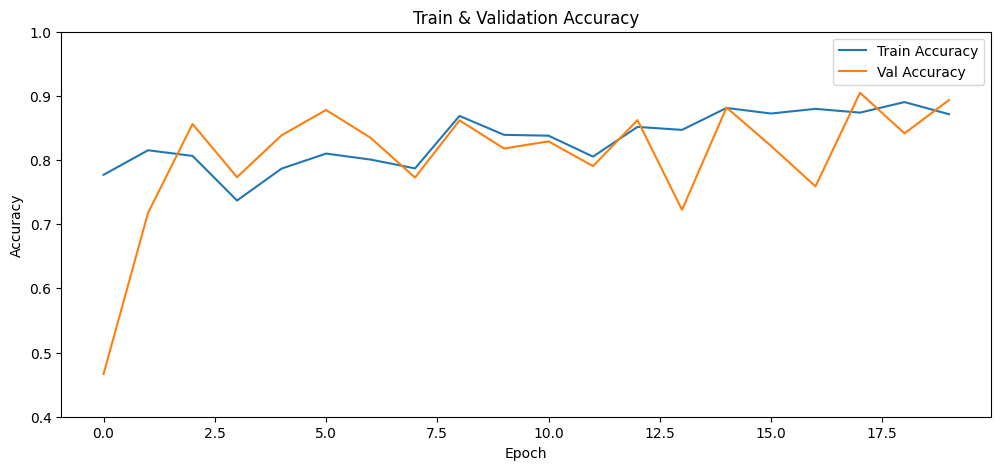

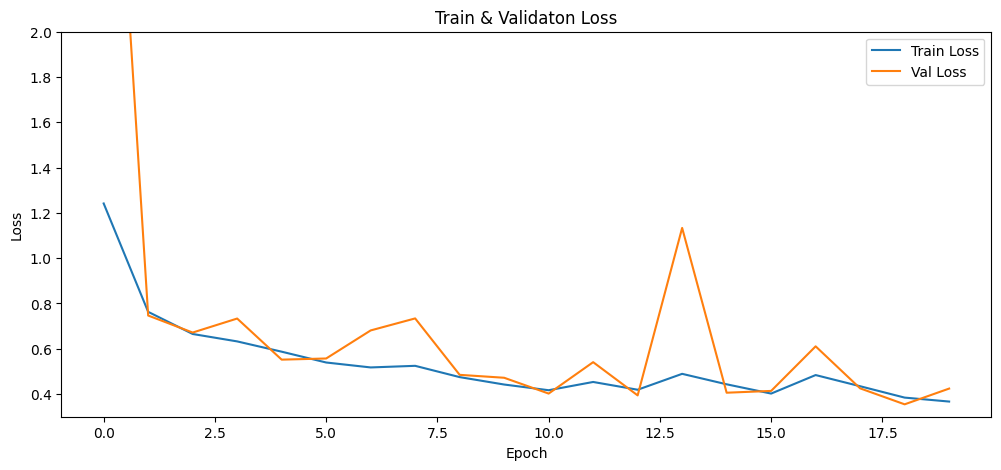

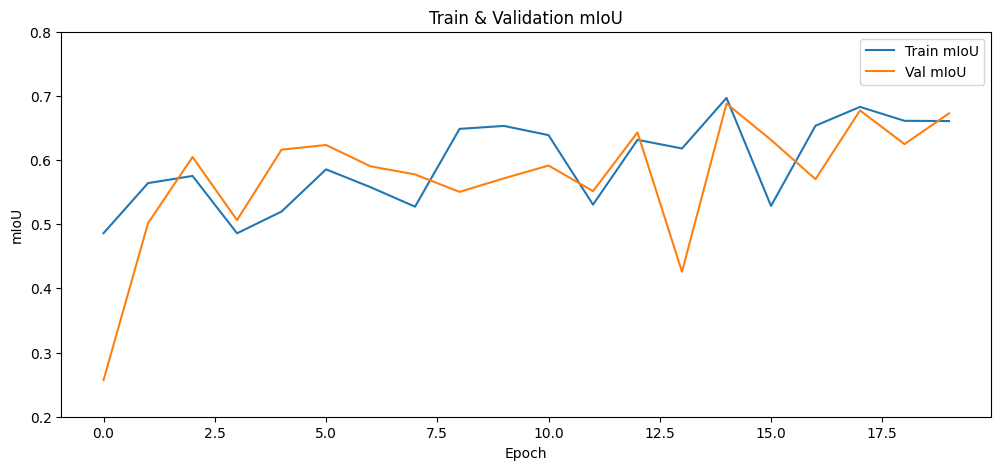

In [ ]:
plt.figure(figsize=(12,5))
plt.ylim(0.4, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Train & Validation Accuracy')

plt.figure(figsize=(12,5))
plt.ylim(0.3, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validaton Loss')

plt.figure(figsize=(12,5))
plt.ylim(0.2, 0.8)
plt.plot(train_mIoUs, label="Train mIoU")
plt.plot(val_mIoUs, label="Val mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Train & Validation mIoU')

In [ ]:
print("Train accuracies :", train_accuracies)
print("Val accuracies   :", val_accuracies)
print("")
print("Train losses     :", train_losses)
print("Val losses       :", val_losses)
print("")
print("Train mIoUs      :", train_mIoUs)
print("Val mIoUs        :", val_mIoUs)

Train accuracies : [0.7770029703776041, 0.8152974446614584, 0.8064727783203125, 0.7369384765625, 0.7866414388020834, 0.810089111328125, 0.8007710774739584, 0.7870330810546875, 0.8687845865885416, 0.8393046061197916, 0.8380025227864584, 0.8053741455078125, 0.8516947428385416, 0.8470052083333334, 0.881195068359375, 0.8725179036458334, 0.8797963460286459, 0.8739064534505209, 0.8903605143229166, 0.8714141845703125]
Val accuracies   : [0.4665184020996094, 0.7176856994628906, 0.856170654296875, 0.7733268737792969, 0.8385162353515625, 0.8780326843261719, 0.8347587585449219, 0.7727127075195312, 0.8618545532226562, 0.8180046081542969, 0.8291015625, 0.7905731201171875, 0.8622398376464844, 0.7223472595214844, 0.8818702697753906, 0.8220138549804688, 0.75897216796875, 0.9048423767089844, 0.8415908813476562, 0.893524169921875]

Train losses     : [1.2416134810043593, 0.7631042983572361, 0.6652938208337558, 0.632572590799655, 0.587177602416378, 0.5394317386514049, 0.5176270427340168, 0.52473753539182

In [ ]:
best_val_model_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
model.load_state_dict(best_val_checkpoint['Model'])

<All keys matched successfully>

In [ ]:
test_miou = test_miou_score(model, test_set)
print("IoU Score: ", np.mean(test_miou))

  0%|          | 0/101 [00:00<?, ?it/s]

IoU Score:  0.6826113571282056


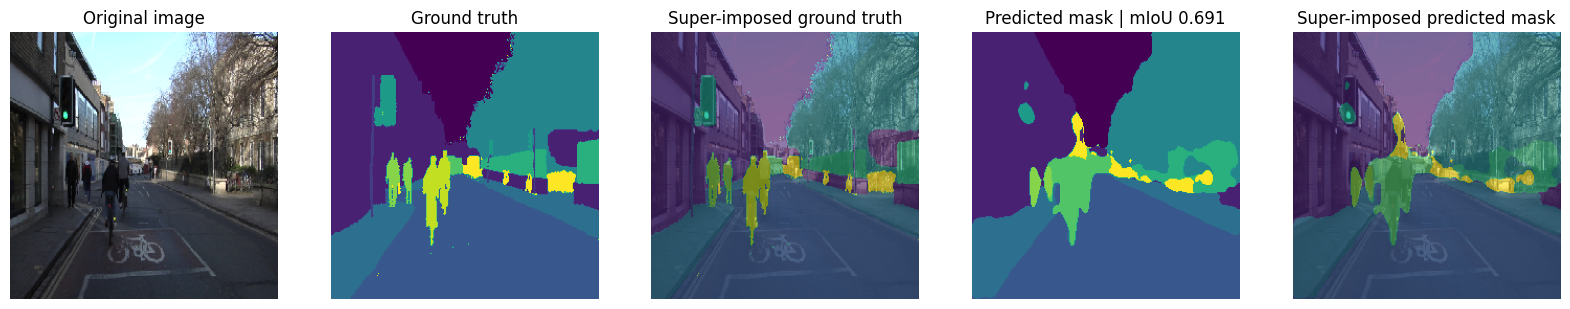

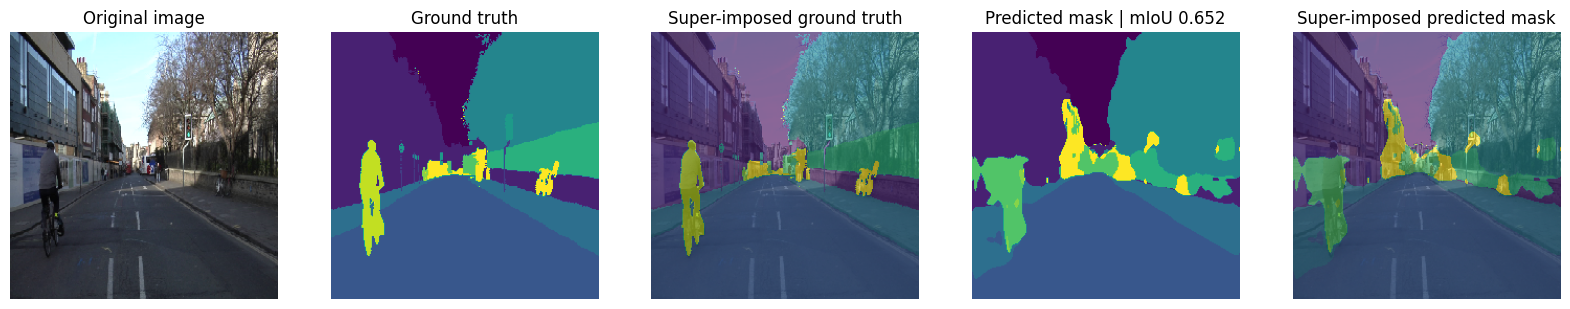

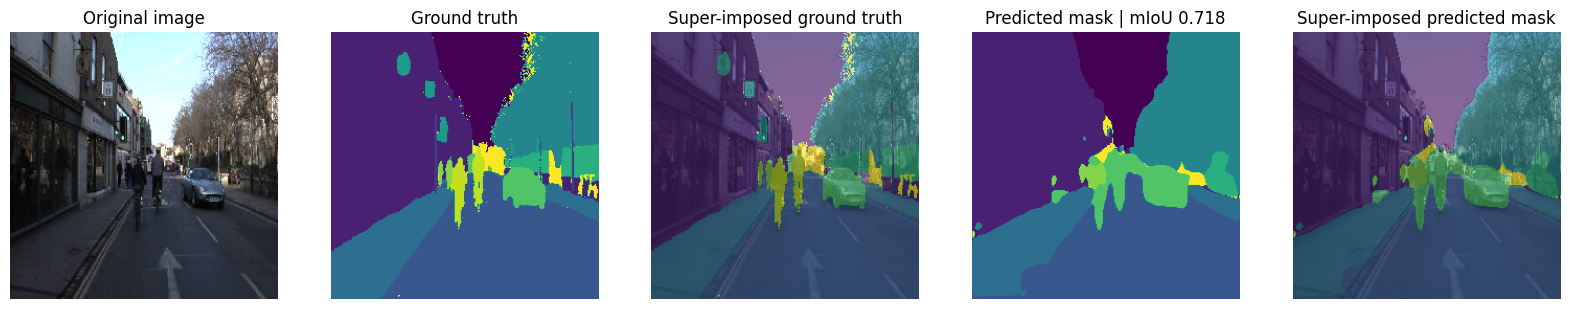

In [ ]:
image1, mask1 = test_set[5]
pred_mask1, score = predict_image_mask_miou(model, image1, mask1)
display_for_comparison(image1, mask1, pred_mask1)

image2, mask2 = test_set[53]
pred_mask2, score = predict_image_mask_miou(model, image2, mask2)
display_for_comparison(image2, mask2, pred_mask2)

image3, mask3 = test_set[96]
pred_mask3, score = predict_image_mask_miou(model, image3, mask3)
display_for_comparison(image3, mask3, pred_mask3)

##**U-Net With MobileNet Encoder**

In [ ]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=12, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.7 MB/s eta 0:00:00


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.1MB/s]


In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

epochs = 20

model.to(device);

In [ ]:
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

start_epoch = 0

In [ ]:
for epoch in range(start_epoch, epochs):

  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU, train_f1, train_dice, train_sensitivity, train_specificity = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  scheduler.step()

  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU, val_f1, val_dice, val_sensitivity, val_specificity  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  print('Train loss: %.4f'%(train_loss))
  print('Val loss: %.4f'%(val_loss))
  print('')
  print('Train accuracy %.2f' % (train_accuracy))
  print('Val accuracy %.2f' % (val_accuracy))
  print('')
  print('Train IoU %.2f'%(train_mIoU))
  print('Val IoU %.2f'%(val_mIoU))
  print('')
  print('Train F1 %.2f' % (train_f1))
  print('Val F1 %.2f' % (val_f1))
  print('')
  print('Train dice %.2f' % (train_dice))
  print('Val dice %.2f' % (val_dice))
  print('')
  print('Train sensitivity %.2f' % (train_sensitivity))
  print('Val sensitivity %.2f' % (val_sensitivity))
  print('')
  print('Train specificity %.2f' % (train_specificity))
  print('Val specificity %.2f' % (val_specificity))
  
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'Model': model.state_dict(),
    'Optimizer': optimizer.state_dict(),
    'Scheduler': scheduler.state_dict(),
    'Trained_epochs': epoch,
    'Train_losses': train_losses,
    'Train_accuracies': train_accuracies,
    'Train_mIoUs': train_mIoUs,
    'Val_losses': val_losses,
    'Val_accuracies': val_accuracies,
    'Val_accuracy_max': val_mIoU_max,
    'Val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("Val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

  # saving checkpoint for the last epoch
  checkpoint = {
    'Model': model.state_dict(),
    'Optimizer': optimizer.state_dict(),
    'Scheduler': scheduler.state_dict(),
    'Trained_epochs': epoch,
    'Train_losses': train_losses,
    'Train_accuracies': train_accuracies,
    'Train_mIoUs': train_mIoUs,
    'Val_losses': val_losses,
    'Val_accuracies': val_accuracies,
    'Val_accuracy_max': val_mIoU_max,
    'Val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2826
Val loss: 0.3071

Train accuracy 0.92
Val accuracy 0.90

Train IoU 0.77
Val IoU 0.68

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.96
Val specificity 0.97
New max val mean IoU Acheived 0.68. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2821
Val loss: 0.2975

Train accuracy 0.87
Val accuracy 0.90

Train IoU 0.68
Val IoU 0.72

Train F1 0.99
Val F1 0.99

Train dice 1.97
Val dice 1.98

Train sensitivity 0.98
Val sensitivity 0.99

Train specificity 0.95
Val specificity 0.95
New max val mean IoU Acheived 0.72. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2804
Val loss: 0.3124

Train accuracy 0.92
Val accuracy 0.87

Train IoU 0.70
Val IoU 0.70

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.97

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.96
Val specificity 0.93
Val mean IoU did not increase from 0.72


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2778
Val loss: 0.3030

Train accuracy 0.88
Val accuracy 0.92

Train IoU 0.66
Val IoU 0.75

Train F1 0.98
Val F1 0.99

Train dice 1.96
Val dice 1.98

Train sensitivity 0.98
Val sensitivity 0.99

Train specificity 0.90
Val specificity 0.98
New max val mean IoU Acheived 0.75. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2758
Val loss: 0.3041

Train accuracy 0.90
Val accuracy 0.89

Train IoU 0.69
Val IoU 0.66

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.97
Val specificity 0.92
Val mean IoU did not increase from 0.75


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2732
Val loss: 0.2966

Train accuracy 0.90
Val accuracy 0.92

Train IoU 0.74
Val IoU 0.77

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.97

Train sensitivity 0.98
Val sensitivity 0.99

Train specificity 0.97
Val specificity 0.94
New max val mean IoU Acheived 0.77. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2692
Val loss: 0.2993

Train accuracy 0.92
Val accuracy 0.92

Train IoU 0.73
Val IoU 0.72

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.92
Val specificity 0.97
Val mean IoU did not increase from 0.77


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2722
Val loss: 0.3097

Train accuracy 0.90
Val accuracy 0.94

Train IoU 0.73
Val IoU 0.74

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.98
Val specificity 0.97
Val mean IoU did not increase from 0.77


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2693
Val loss: 0.2975

Train accuracy 0.90
Val accuracy 0.93

Train IoU 0.67
Val IoU 0.70

Train F1 0.99
Val F1 0.99

Train dice 1.99
Val dice 1.99

Train sensitivity 1.00
Val sensitivity 0.99

Train specificity 0.97
Val specificity 0.98
Val mean IoU did not increase from 0.77


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2701
Val loss: 0.3078

Train accuracy 0.88
Val accuracy 0.89

Train IoU 0.68
Val IoU 0.71

Train F1 0.99
Val F1 0.99

Train dice 1.97
Val dice 1.97

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.96
Val specificity 0.94
Val mean IoU did not increase from 0.77


Epoch 10: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 10: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2701
Val loss: 0.3051

Train accuracy 0.88
Val accuracy 0.88

Train IoU 0.70
Val IoU 0.70

Train F1 0.98
Val F1 0.98

Train dice 1.96
Val dice 1.97

Train sensitivity 0.97
Val sensitivity 0.98

Train specificity 0.95
Val specificity 0.95
Val mean IoU did not increase from 0.77


Epoch 11: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 11: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2671
Val loss: 0.2981

Train accuracy 0.93
Val accuracy 0.90

Train IoU 0.66
Val IoU 0.68

Train F1 0.99
Val F1 0.99

Train dice 1.97
Val dice 1.97

Train sensitivity 0.98
Val sensitivity 0.98

Train specificity 0.95
Val specificity 0.95
Val mean IoU did not increase from 0.77


Epoch 12: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 12: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2638
Val loss: 0.3244

Train accuracy 0.91
Val accuracy 0.87

Train IoU 0.71
Val IoU 0.69

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.98
Val sensitivity 0.99

Train specificity 0.95
Val specificity 0.93
Val mean IoU did not increase from 0.77


Epoch 13: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 13: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2623
Val loss: 0.2999

Train accuracy 0.90
Val accuracy 0.87

Train IoU 0.73
Val IoU 0.69

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.97

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.96
Val specificity 0.93
Val mean IoU did not increase from 0.77


Epoch 14: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 14: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2631
Val loss: 0.3114

Train accuracy 0.92
Val accuracy 0.85

Train IoU 0.73
Val IoU 0.63

Train F1 0.99
Val F1 0.98

Train dice 1.98
Val dice 1.97

Train sensitivity 0.99
Val sensitivity 0.98

Train specificity 0.92
Val specificity 0.94
Val mean IoU did not increase from 0.77


Epoch 15: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 15: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2623
Val loss: 0.3033

Train accuracy 0.87
Val accuracy 0.93

Train IoU 0.67
Val IoU 0.72

Train F1 0.99
Val F1 0.99

Train dice 1.97
Val dice 1.99

Train sensitivity 0.98
Val sensitivity 0.99

Train specificity 0.96
Val specificity 0.98
Val mean IoU did not increase from 0.77


Epoch 16: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 16: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2626
Val loss: 0.2947

Train accuracy 0.90
Val accuracy 0.88

Train IoU 0.74
Val IoU 0.73

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.98
Val specificity 0.96
Val mean IoU did not increase from 0.77


Epoch 17: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 17: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2612
Val loss: 0.3055

Train accuracy 0.91
Val accuracy 0.89

Train IoU 0.76
Val IoU 0.71

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.99

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.96
Val specificity 0.98
Val mean IoU did not increase from 0.77


Epoch 18: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 18: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2595
Val loss: 0.2953

Train accuracy 0.94
Val accuracy 0.91

Train IoU 0.75
Val IoU 0.70

Train F1 0.99
Val F1 0.99

Train dice 1.99
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.98
Val specificity 0.96
Val mean IoU did not increase from 0.77


Epoch 19: Train 
Learning Rate: 0.001000


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 19: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.2583
Val loss: 0.2934

Train accuracy 0.90
Val accuracy 0.91

Train IoU 0.73
Val IoU 0.72

Train F1 0.99
Val F1 0.99

Train dice 1.98
Val dice 1.98

Train sensitivity 0.99
Val sensitivity 0.99

Train specificity 0.97
Val specificity 0.95
Val mean IoU did not increase from 0.77




Text(0.5, 1.0, 'Train & Validation mIoU')

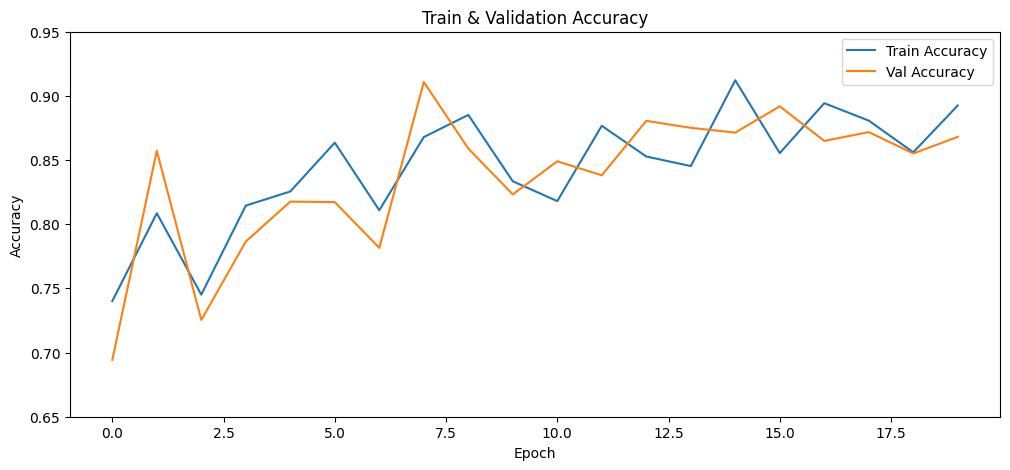

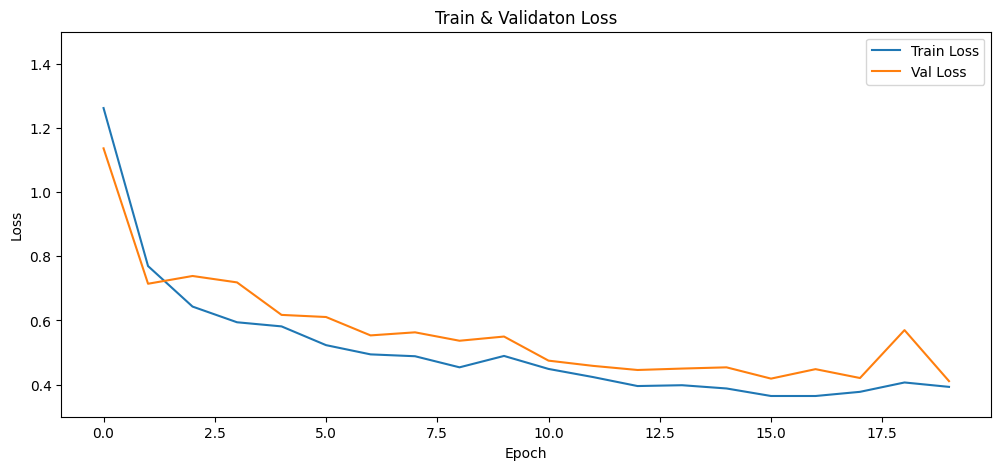

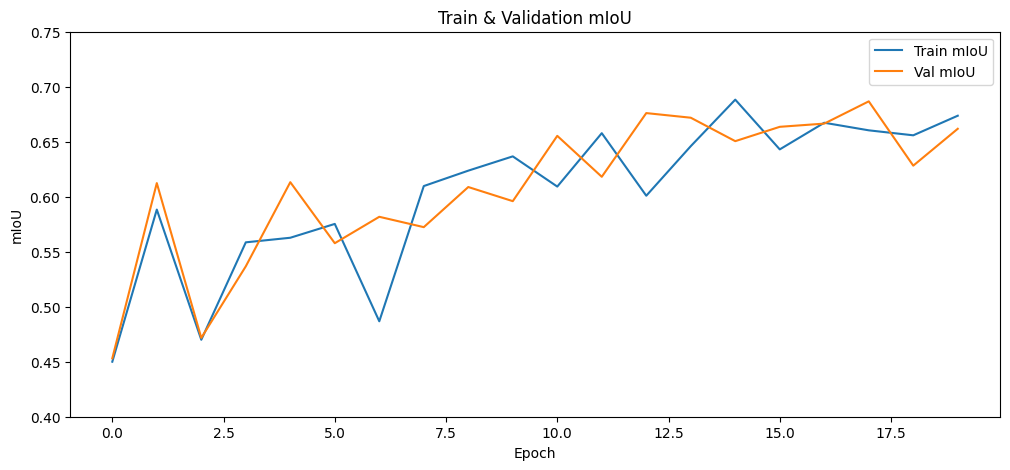

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Train & Validation Accuracy')

plt.figure(figsize=(12,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validaton Loss')

plt.figure(figsize=(12,5))
plt.plot(train_mIoUs, label="Train mIoU")
plt.plot(val_mIoUs, label="Val mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Train & Validation mIoU')

In [ ]:
best_val_model_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
model.load_state_dict(best_val_checkpoint['Model'])

<All keys matched successfully>

In [ ]:
test_miou = test_miou_score(model, test_set)
print("IoU Score: ", np.mean(test_miou))

  0%|          | 0/101 [00:00<?, ?it/s]

0.7125305081964433

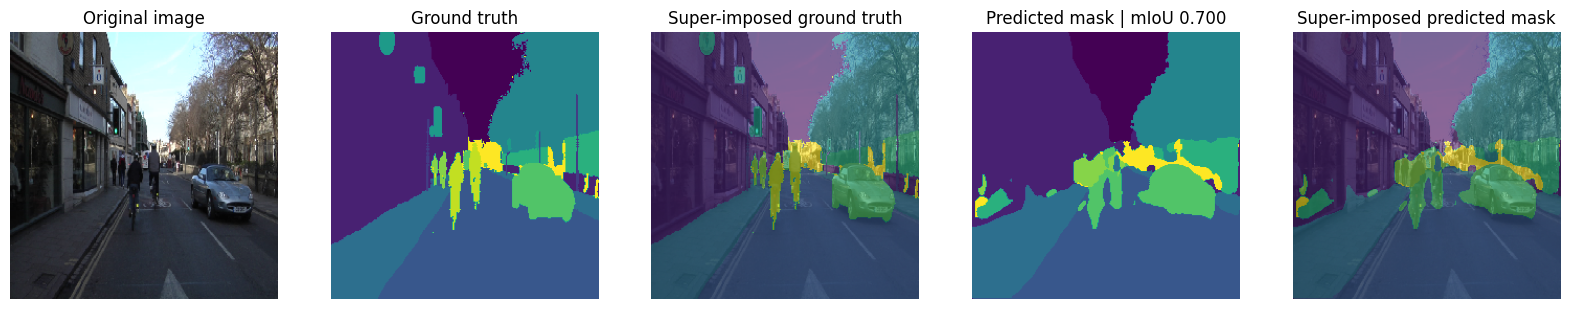

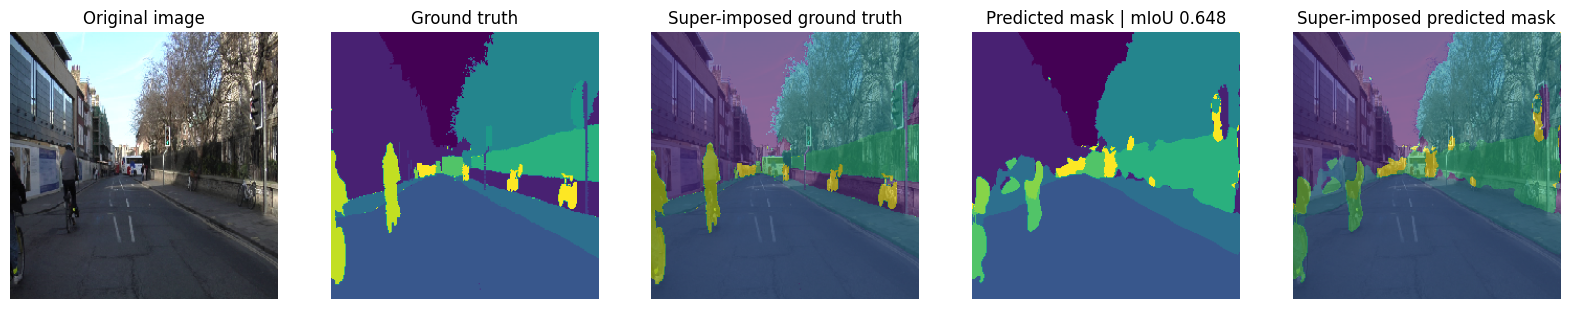

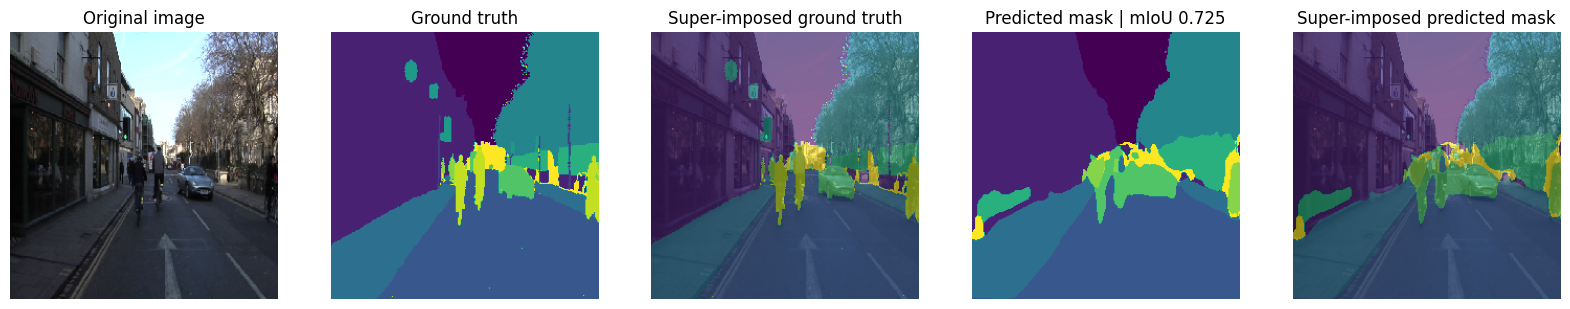

In [ ]:
image1, mask1 = test_set[3]
pred_mask1, score = predict_image_mask_miou(model, image1, mask1)
display_for_comparison(image1, mask1, pred_mask1)

image2, mask2 = test_set[51]
pred_mask2, score = predict_image_mask_miou(model, image2, mask2)
display_for_comparison(image2, mask2, pred_mask2)

image3, mask3 = test_set[94]
pred_mask3, score = predict_image_mask_miou(model, image3, mask3)
display_for_comparison(image3, mask3, pred_mask3)